In [1]:
import os
import re
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

def set_style(tick_label_size=16, font_size=18):
    import matplotlib
    matplotlib.rc('xtick', labelsize=tick_label_size)
    matplotlib.rc('ytick', labelsize=tick_label_size)
    matplotlib.rc('font', size=font_size)

set_style()

In [2]:
import jax
import flax
from flax import nn, optim, serialization

In [3]:
from lib.params import mdn

In [4]:
path_data = './mcsamples'
path_models = './dat'

In [5]:
def get_vars(data):
    """ """
    e, mddsq, md1pisq = [data[:,i] for i in range(3)]
    tdd = (np.sqrt(mddsq) - 2*mdn)*10**3
    mask = tdd > 0
    pd = np.sqrt(np.clip(tdd, 0, None) * mdn * 10**3)
    md1pi = np.sqrt(md1pisq)
    return np.column_stack([e[mask], pd[mask], md1pi[mask]])

In [6]:
def smeared_samp_file(re, im, ch):
    return f'mc_ddpip_3d_gs{re:.2f}_{im:.2f}_ch{ch}_smeared.npy'

In [7]:
def get_sample(re, im, ch):
    return get_vars(np.load(os.path.join(path_data, smeared_samp_file(re, im, ch))))

In [8]:
def draw_1d_projections(ax, data, bins=250, weights=None, alpha=None, density=False, lims=None):
    if not lims:
        lims = [(-3, 10), (0, 150), (2.004, 2.016)]
    labels = [r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (GeV)']
    for idx, (lbl, l) in enumerate(zip(labels, lims)):
        ax[idx].hist(data[:,idx], bins=bins, weights=weights, alpha=alpha, density=density, range=l);
        ax[idx].grid()
        ax[idx].set_xlabel(lbl)

In [9]:
parset1 = (44, 1.8)
parset2 = (44, 1.2)

In [10]:
sample1 = get_sample(*parset1, 250)[:80000]
sample1.shape

(80000, 3)

In [11]:
# sample2 = get_sample(36, 1.2, 250)[:80000]
sample2 = get_sample(*parset2, 250)[:80000]
sample2.shape

(80000, 3)

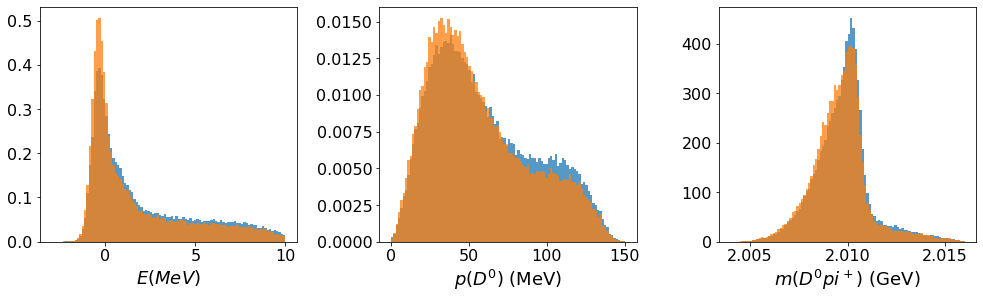

In [12]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4.5))
draw_1d_projections(ax, sample1, bins=100, weights=None, alpha=0.75, density=True)
draw_1d_projections(ax, sample2, bins=100, weights=None, alpha=0.75, density=True);
fig.tight_layout()

In [13]:
def uniform_sample(rg, limits, N):
    """ """
    lo = [x[0] for x in limits]
    hi = [x[1] for x in limits]
    return rg.uniform(lo, hi, (N, len(limits)))

In [14]:
def norm_sample(rg, samp, mult=10):
    norm_size = mult*samp.shape[0]
    limits = [[np.min(samp[:, i]), np.max(samp[:, i])] for i in range(samp.shape[1])]
    return uniform_sample(rg, limits, norm_size)

In [15]:
rg = np.random.Generator(np.random.PCG64())

In [16]:
norm1 = norm_sample(rg, sample1, mult=10)
norm1.shape

(800000, 3)

In [17]:
norm2 = norm_sample(rg, sample2, mult=10)
norm2.shape

(800000, 3)

In [18]:
class NN(nn.Module):
    def apply(self, x):
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=32)
        x = nn.relu(x)
        x = nn.Dense(x, features=16)
        x = nn.relu(x)
        x = nn.Dense(x, features=1)
        return nn.sigmoid(x)
    
@flax.struct.dataclass
class TrainState:
    optimizer: optim.Optimizer
        
def model_file(re, im, ch):
    return f'nn_model_3d_gs{re:.2f}_{im:.2f}_ch{ch}.dat'

def norm_file(re, im, ch):
    return f'norm_gs{re:.2f}_{im:.2f}_ch{ch}.npz'

def get_norm(re, im, ch):
    fname = os.path.join(path_models, norm_file(re, im, ch))
    if not os.path.isfile(fname):
        print('get_norm: {fname} not found')
    ndata = np.load(fname)
    return (ndata['mean'], ndata['std'])

def read_model(re, im, ch):
    key = jax.random.PRNGKey(0)
    _, initial_params = NN.init(key, np.zeros((10, 3)))
    
    model = nn.Model(NN, initial_params)
    
    adam = optim.Adam(learning_rate=0.003)
    optimizer = adam.create(model)
    
    state = TrainState(optimizer=optimizer)
    means, stds = get_norm(re, im, ch)
        
    with open(os.path.join(path_models, model_file(re, im, ch)), 'rb') as f:
        data = f.read()
        
    restored_state = flax.serialization.from_bytes(state, data)
    jax.tree_map(np.shape, flax.serialization.to_state_dict(restored_state))
        
    model = nn.Model(NN, initial_params)
    for layer in range(4):
        model.params[f'Dense_{layer}'] =\
            restored_state.optimizer.state_dict()['target']['params'][f'Dense_{layer}']
        
    def pdf(data):
        norm_data = np.empty(data.shape)
        for idx, (m, s) in enumerate(zip(means, stds)):
            norm_data[:, idx] = (data[:, idx] - m) / s
        return np.array(model(norm_data))
    return pdf

In [19]:
model1 = read_model(*parset1, 250)

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [20]:
model2 = read_model(*parset2, 250)

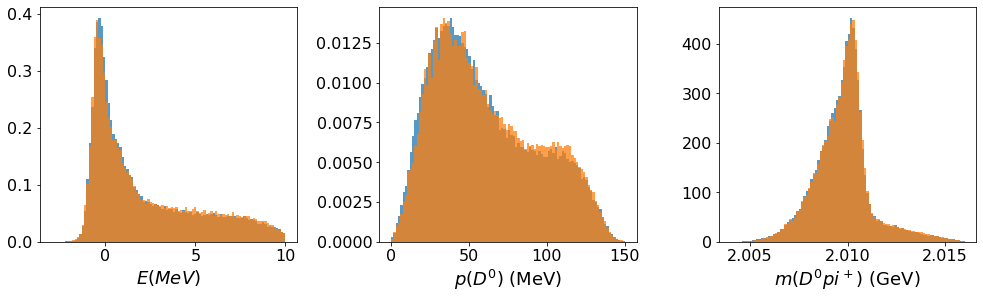

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4.5))
draw_1d_projections(ax, sample1, bins=100, weights=None, alpha=0.75, density=True)
draw_1d_projections(ax, norm1, bins=100, weights=model1(norm1), alpha=0.75, density=True);
fig.tight_layout()

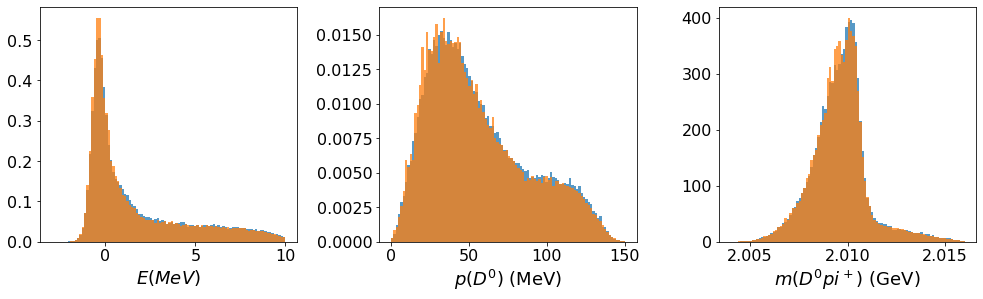

In [22]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4.5))
draw_1d_projections(ax, sample2, bins=100, weights=None, alpha=0.75, density=True)
draw_1d_projections(ax, norm2, bins=100, weights=model2(norm2), alpha=0.75, density=True);
fig.tight_layout()

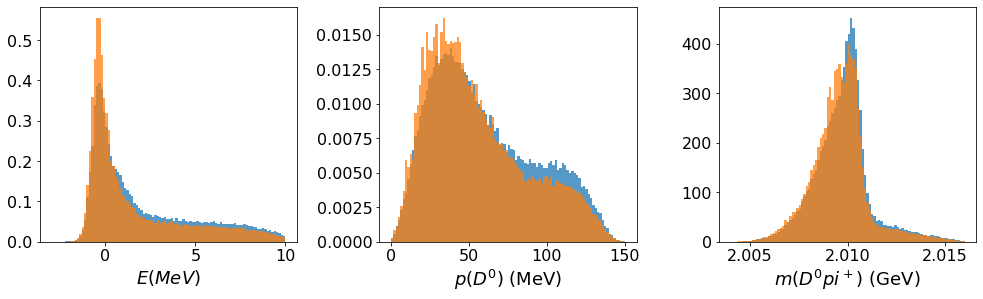

In [23]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4.5))
draw_1d_projections(ax, sample1, bins=100, weights=None, alpha=0.75, density=True)
draw_1d_projections(ax, norm2, bins=100, weights=model2(norm2), alpha=0.75, density=True);
fig.tight_layout()

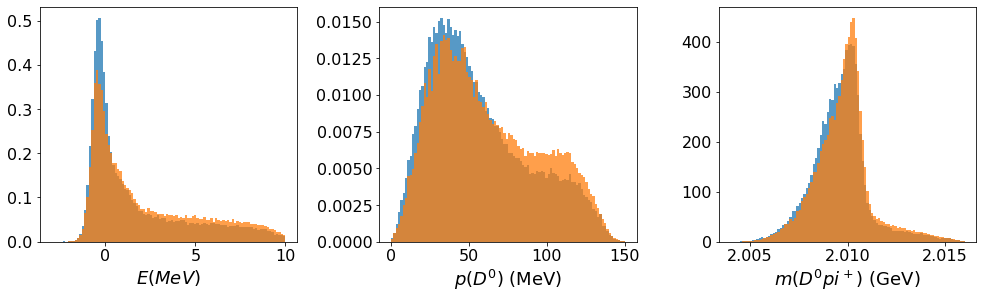

In [24]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4.5))
draw_1d_projections(ax, sample2, bins=100, weights=None, alpha=0.75, density=True)
draw_1d_projections(ax, norm1, bins=100, weights=model1(norm1), alpha=0.75, density=True);
fig.tight_layout()

In [25]:
def unbinned_loglh(rg, model, sample):
    return -np.sum(np.log(model(sample))) +\
        sample.shape[0] * (np.log(np.mean(model(norm_sample(rg, sample, 100)))))

In [26]:
unbinned_loglh(rg, model1, sample1) / sample1.shape[0]

-2.827896221923828

In [27]:
unbinned_loglh(rg, model1, sample2) / sample2.shape[0]

-2.9651214492797853

In [28]:
unbinned_loglh(rg, model2, sample2) / sample2.shape[0]

-2.9882275650024415

In [29]:
unbinned_loglh(rg, model2, sample1) / sample1.shape[0]

-2.7994251037597655